In [1]:
import sys
sys.path.append('../python/')

#matplotlib for plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import lmfit as lm
import emcee as mc
import numpy as np
import corner
import scipy
import pandas as pds
from scipy.optimize import minimize

plt.style.use('mplstyles/stylelib/standard.mplstyle')

#other computational libraries
import numpy as np

506.1574


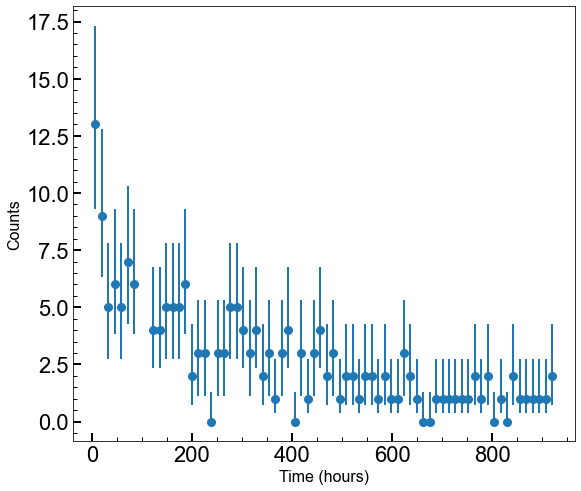

[13  9  5  6  5  7  6  4  4  5  5  5  6  2  3  3  0  3  3  5  5  4  3  4
  2  3  1  3  4  0  3  1  3  4  2  3  1  2  2  1  2  2  1  2  1  1  3  2
  1  0  0  1  1  1  1  1  1  2  1  2  0  1  0  2  1  1  1  1  1  2]


In [2]:
ge_data = pds.read_csv("SuperCDMS/PhysRevD.99.062001-data/MarchAprilFinal.txt", skiprows=1, \
                         names=['time', 'blah'], \
                         delim_whitespace=False
                     )

ge_data = ge_data.sort_values(by='time')

#print (ge_data.head(10))

t = np.asarray(ge_data["time"], dtype=np.float32)

min_t=np.min(t)
print(min_t)

counts, bins = np.histogram(t-min_t,bins=72)

#thing is the x values
thing = (bins[:-1]+bins[1:])/2
counts = np.delete(counts, [7,8])
thing = np.delete(thing, [7,8])

fig,axes = plt.subplots(1,1, figsize=(9,8))
error1 = [0.00,0.37,0.74,1.10,2.34,2.75,3.82,4.25,5.30,6.33,6.78,7.81,8.83,9.28]
error2 = [1.29,2.75,4.25,5.30,6.78,7.81,9.28,10.30,11.32,12.79,13.81,14.82,16.29,17.30]
ntot = counts

ntot_plus = np.zeros(np.shape(ntot))
ntot_minus = np.zeros(np.shape(ntot))
for i,ncount in enumerate(ntot):
    if ncount<=20:
        ntot_plus[i] = error2[ncount]-ncount
        ntot_minus[i] = ncount-error1[ncount]
    else:
        ntot_plus[i] = np.sqrt(ncount)
        ntot_minus[i] = np.sqrt(ncount)

#counts.tolist()
#thing.tolist()
#counts.pop(9)
#counts.pop(10)
#thing.pop(9)
#thing.pop(10)


ax1=axes
ax1.errorbar(thing, counts, yerr=[ntot_minus,ntot_plus], marker='o', markersize=8, linestyle = 'none')
plt.xlabel("Time (hours)", fontsize=16)
plt.ylabel("Counts", fontsize=16)
plt.show(fig)
#print(thing,counts)

weight = (1/((ntot_plus+ntot_minus)/2))
print(counts)

[7.46570029 7.30412879 7.1480348  6.99723263 6.85154286 6.7107922
 6.57481318 6.44344405 6.31652853 6.19391562 6.07545948 5.96101916
 5.85045854 5.74364609 5.64045474 5.54076172 5.44444844 5.35140032
 5.26150667 5.17466054 5.09075863 5.00970111 4.93139155 4.85573681
 4.78264687 4.71203479 4.64381656 4.57791103 4.51423979 4.4527271
 4.39329977 4.33588712 4.28042085 4.22683496 4.17506571 4.12505151
 4.07673287 4.0300523  3.98495427 3.94138513 3.89929304 3.85862794
 3.81934144 3.78138682 3.74471891 3.70929409 3.67507023 3.64200661
 3.61006389 3.57920408 3.54939046 3.52058756 3.49276113 3.46587805
 3.43990635 3.41481512 3.39057453 3.36715572 3.34453085 3.322673
 3.30155615 3.2811552  3.26144587 3.24240472 3.22400909 3.20623709
 3.1890676  3.17248017 3.15645508 3.14097327 3.12601631 3.11156642
 3.09760639 3.08411964 3.0710901  3.05850228 3.04634121 3.03459242
 3.02324193 3.01227623 3.00168229 2.9914475  2.98155968 2.97200708
 2.96277832 2.95386243 2.9452488  2.93692719 2.92888769 2.92112074

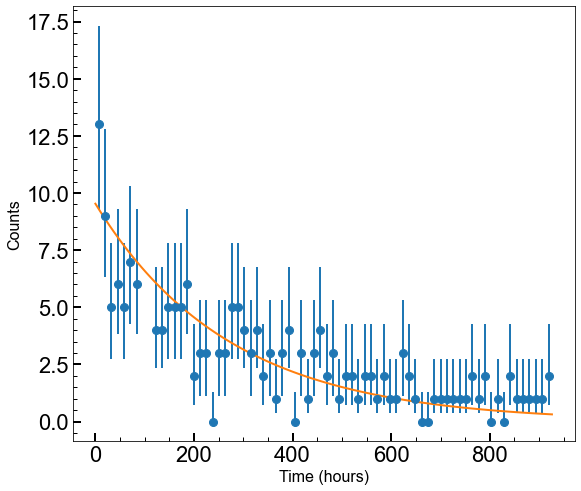

In [3]:
def function(t, tstop, alpha, B):
    return(2500*((1/(1+B))*np.exp(-t/alpha)/(alpha*(1-np.exp(-tstop/alpha)))+(B)/tstop))
           
#print(function(1,2,3,4))
fig,axes = plt.subplots(1,1, figsize=(9,8))

ax1=axes
ax1.errorbar(thing, counts, yerr=[ntot_minus,ntot_plus], marker='o', markersize=8, linestyle = 'none')

#print(function(0,1450,271.2,1)*4000)
x = np.linspace(0,926,num=100) #i cant remember why we chose 926
print (function(x,926,271.2,1))

plt.xlabel("Time (hours)", fontsize=16)
plt.ylabel("Counts", fontsize = 16)
ax1.plot(x,function(x,926,271.2,0))
plt.show(fig)

In [4]:
f_mod = lm.Model(function)
f_params = f_mod.make_params()               # define parameters

f_params.add('alpha',     vary=True,  value=271.2, min=0)  # half life

# amplitude
f_params.add('B', vary=True,  value=0,      min=0,max=100)  
# time
f_params.add('tstop',  vary=False,  value=926)

#do the fitting
counts1 = counts/np.sum(counts)
weight1 = weight*np.sum(counts)
f_fit = f_mod.fit(counts1, f_params, t = thing, weights = weight1)

f_fit

In [5]:
def log_likelihood_func(theta, t_stop, times, nvec): 
    alpha,b,scale=theta
   
    #initialize array of lambdas for each bin according to our model
    lam_array = [] 
    for i in range(len(nvec)):
        result = scale*((1/(1+b))*np.exp(-times[i]/alpha)/(alpha*(1-np.exp(-t_stop/alpha)))+(b)/t_stop)
        lam_array.extend([result])
    
    #Sterling's approximation array
    sterling_array = []
    for i in range(len(nvec)):
        if nvec[i]>12:
                sterling_array.append(nvec[i]*np.log(nvec[i])-nvec[i])
        else:
                sterling_array.append(np.log(np.math.factorial(nvec[i])))
    
    model = 0
    for i in range(len(nvec)):
        model +=(-lam_array[i] + nvec[i]*np.log(lam_array[i])-sterling_array[i])
    return model

def prior(theta): #this sets the prior conditions of our parameters
    alpha, b, scale= theta
    if alpha>=0 and b>=0 and scale>0:
        return 0.0
    return -np.inf

def prob(theta, t_stop, times, nvec):
    lp = prior(theta)
    if not np.isfinite(lp):
        return -np.inf 
    result = lp + log_likelihood_func(theta, t_stop, times, nvec)
    if np.isnan(np.asarray([result])):
        return -np.inf
    return result

alpha = 250
b=1
tstop = 1440
scale=2000

nll = lambda *args: -log_likelihood_func(*args)
initial = np.array([alpha,b,scale])  
soln = scipy.optimize.minimize(nll, initial, args=(tstop, thing, counts), bounds=[(0,np.inf),(0,50),(0,np.inf)]) #add bounds?
alphaml, bml, scaleml = soln.x
print(soln.x)

pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = mc.EnsembleSampler(
    nwalkers, ndim, prob, args=(tstop, thing, counts)
)

sampler.run_mcmc(pos, 7000, progress=True);

[2.38183692e+02 4.73754786e-01 2.61461421e+03]


100%|██████████| 7000/7000 [04:58<00:00, 23.48it/s]


[44.81024113 43.65666632 40.03838585]
(14720, 3)
238.18369216644575 0.47375478622631734 2614.6142091165902


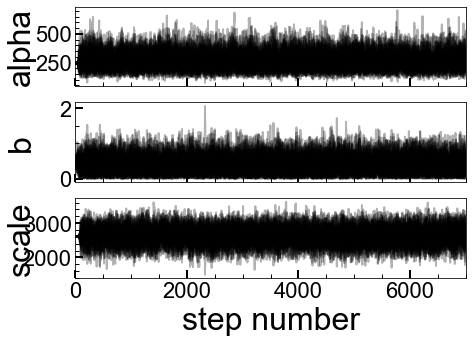

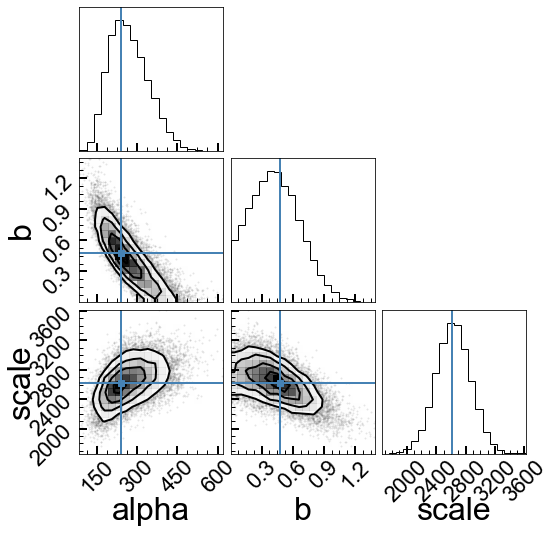

In [6]:
fig, axes = plt.subplots(3, figsize=(7, 5), sharex=True)
samples = sampler.get_chain()
labels = ["alpha","b","scale"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

tau = sampler.get_autocorr_time()
print(tau)

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)
print(alphaml,bml,scaleml)

fig = corner.corner(
    flat_samples, labels=labels, truths=[alphaml, bml,scaleml]
);

[7.46570029 7.30412879 7.1480348  6.99723263 6.85154286 6.7107922
 6.57481318 6.44344405 6.31652853 6.19391562 6.07545948 5.96101916
 5.85045854 5.74364609 5.64045474 5.54076172 5.44444844 5.35140032
 5.26150667 5.17466054 5.09075863 5.00970111 4.93139155 4.85573681
 4.78264687 4.71203479 4.64381656 4.57791103 4.51423979 4.4527271
 4.39329977 4.33588712 4.28042085 4.22683496 4.17506571 4.12505151
 4.07673287 4.0300523  3.98495427 3.94138513 3.89929304 3.85862794
 3.81934144 3.78138682 3.74471891 3.70929409 3.67507023 3.64200661
 3.61006389 3.57920408 3.54939046 3.52058756 3.49276113 3.46587805
 3.43990635 3.41481512 3.39057453 3.36715572 3.34453085 3.322673
 3.30155615 3.2811552  3.26144587 3.24240472 3.22400909 3.20623709
 3.1890676  3.17248017 3.15645508 3.14097327 3.12601631 3.11156642
 3.09760639 3.08411964 3.0710901  3.05850228 3.04634121 3.03459242
 3.02324193 3.01227623 3.00168229 2.9914475  2.98155968 2.97200708
 2.96277832 2.95386243 2.9452488  2.93692719 2.92888769 2.92112074

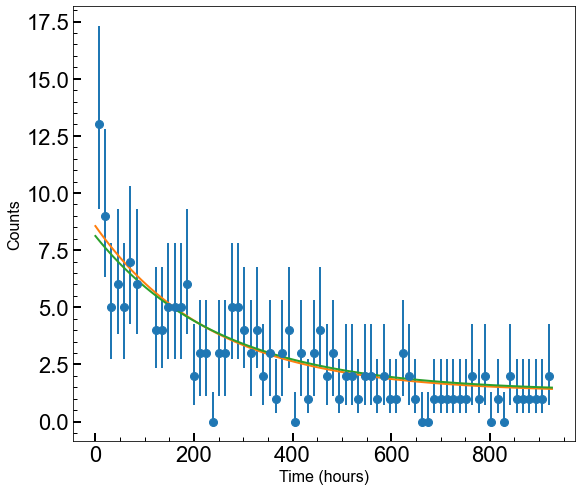

In [10]:
fig,axes = plt.subplots(1,1, figsize=(9,8))

ax1=axes
ax1.errorbar(thing, counts, yerr=[ntot_minus,ntot_plus], marker='o', markersize=8, linestyle = 'none')

#print(function(0,1450,271.2,1)*4000)
x = np.linspace(0,926,num=100) #i cant remember why we chose 926
print (function(x,926,271.2,1))

plt.xlabel("Time (hours)", fontsize=16)
plt.ylabel("Counts", fontsize = 16)
ax1.plot(x,function(x,926,238.1,0.473))
ax1.plot(x,function(x,926,253.897,0.48402))
plt.show(fig)

